In [50]:
import os
os.environ['DGLBACKEND'] = 'mxnet'
import dgl
import networkx as nx
import mxnet as mx
from mxnet import gluon
import math
import numpy as np
import dgl.function as fn

In [2]:
def disjoint_chains(n_chains, length):
    path_graph = nx.path_graph(n_chains * length).to_directed()
    for i in range(n_chains - 1):  # break the path graph into N chains
        path_graph.remove_edge((i + 1) * length - 1, (i + 1) * length)
        path_graph.remove_edge((i + 1) * length, (i + 1) * length - 1)
    for n in path_graph.nodes:
        path_graph.add_edge(n, n)  # add self connections
    return path_graph

In [3]:
g1 = disjoint_chains(1, 30)
nx.draw(g1, pos=nx.circular_layout(g1))

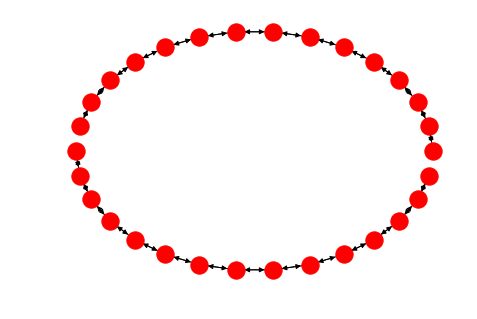

In [4]:
g2 = disjoint_chains(2, 15)
nx.draw(g2, pos=nx.circular_layout(g2))

In [242]:
n_train_samples = 5000
n_epochs = 100
lr = 1e-3
weight_decay = 5e-4

g = dgl.DGLGraph(disjoint_chains(1, 10000), readonly=True)
labels = mx.nd.zeros([g.number_of_nodes()])
labels[mx.nd.arange(0, g.number_of_nodes(), 2)] = 1
pattern = [0, 1, 1, 0, 1, 1, 1, 0]
for i in range(int(g.number_of_nodes()/len(pattern))):
    labels[i*len(pattern):(i + 1) * len(pattern)] = pattern

train_mask = mx.nd.zeros((g.number_of_nodes()))
train_mask[0:n_train_samples] = 1
eval_mask = mx.nd.zeros((g.number_of_nodes()))
eval_mask[n_train_samples:] = 1


def evaluate(pred, labels, mask):
    pred = pred.argmax(axis=1)
    accuracy = ((pred == labels) * mask).sum() / mask.sum().asscalar()
    return accuracy.asscalar()

# Helper function to convert a number 
# to its fixed width binary representation
def conv(x):
  a = format(x, '032b')
  l = list(str(a))
  l = np.array(list(map(int, l)))
  return l

## Here we predict with MLP

In [243]:
n_hidden = 16
n_classes = 2

class MLP(gluon.Block):
    def __init__(self,
                 n_hidden,
                 n_classes,
                 activation,):
        super(MLP, self).__init__()
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        return self.dense2(self.dense1(h))
    
model = MLP(n_hidden, n_classes, 'relu')
model.initialize()
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
trainer = gluon.Trainer(model.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(100):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print("loss: " + str(loss.asnumpy()) + ", acc: " + str(acc))

loss: [0.6131182], acc: 0.6486


## Here we define a GCN model

In [244]:
n_hidden = 16
n_classes = 2

class GCNLayer(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 out_feats,
                 activation):
        super(GCNLayer, self).__init__()
        self.g = g
        self.dense = gluon.nn.Dense(out_feats, activation=activation)

    def forward(self, h):
        self.g.ndata['h'] = h
        def concat_msg(edges):
            return {'m': edges.src['h']}
        def red_func(nodes):
            m = nodes.mailbox['m']
            if m.shape[1] == 3:
                h = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(h, nodes.data['h'], dim=1)
            else:
                num_feats = m.shape[2]
                m = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(m, nodes.data['h'], mx.nd.zeros(shape=(m.shape[0], num_feats)), dim=1)
            return {'h': self.dense(h)}
        self.g.update_all(concat_msg, red_func)
        return mx.nd.concat(self.g.ndata.pop('h'), h, dim=1)

class GCN(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.layers = gluon.nn.Sequential()
        # input layer
        self.layers.add(GCNLayer(g, in_feats, n_hidden, activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GCNLayer(g, n_hidden, n_hidden, activation))
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return self.dense2(self.dense1(h))

In [ ]:
degs = g.in_degrees().astype('float32')
norm = mx.nd.power(degs, -0.5)
g.ndata['norm'] = mx.nd.expand_dims(norm, 1)
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
model = GCN(g, in_feats=features.shape[1], n_hidden=16, n_classes=2, n_layers=2, activation='relu', dropout=0.5)
model.initialize()
trainer = gluon.Trainer(model.collect_params(), 'adam',
            {'learning_rate': lr, 'wd': weight_decay})

h = model(features)
loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(100):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print(acc)

## here we define an SSE model

In [169]:
class SteadyStateOperator(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(SteadyStateOperator, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(n_hidden)

    def forward(self, g):
        def concat_msg(edges):
            return {'m': edges.src['xh']}
        def red_func(nodes):
            m = nodes.mailbox['m']
            if m.shape[1] == 3:
                h = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(h, nodes.data['h'], dim=1)
            else:
                num_feats = m.shape[2]
                m = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(m, nodes.data['h'], mx.nd.zeros(shape=(m.shape[0], num_feats)), dim=1)
            return {'h': self.dense2(self.dense1(h))}
        
        g.ndata['xh'] = mx.nd.concat(g.ndata['x'], g.ndata['h'], dim=1)
        g.update_all(concat_msg, red_func)
        return g.ndata['h']

def update_embeddings(g, steady_state_operator):
    prev_h = g.ndata['h']
    next_h = steady_state_operator(g)
    g.ndata['h'] = (1 - alpha) * prev_h + alpha * next_h
    
class Predictor(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(Predictor, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(2)  ## binary classifier

    def forward(self, g):
        g.ndata['z'] = self.dense2(self.dense1(g.ndata['h']))
        return g.ndata['z']

In [170]:
n = g.number_of_nodes()
n_hidden = 32
n_embedding_updates = 1
n_parameter_updates = 1
alpha = 0.1
batch_size = 64
lr = 1e-1

g.ndata['x'] = mx.nd.array([conv(i) for i in range(n)])
#g.ndata['x'] = mx.nd.arange(n).reshape(n, 1)
g.ndata['h'] = mx.nd.random.normal(shape=(n, n_hidden))

steady_state_operator = SteadyStateOperator(n_hidden, 'relu')
steady_state_operator.initialize()
predictor = Predictor(n_hidden, 'relu')
predictor.initialize()
trainer = gluon.Trainer(predictor.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

def update_parameters(g, trainer):
    with mx.autograd.record():
        steady_state_operator(g)
        z = predictor(g)
        loss = loss_fcn(z, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
        print("loss: " + str(loss.asnumpy()))
    loss.backward()
    trainer.step(1)  # divide gradients by the number of labelled nodes
    return loss.asnumpy()[0]

def train(g, trainer):
     # first phase
    for i in range(n_embedding_updates):
        update_embeddings(g, steady_state_operator)
    # second phase
    for i in range(n_parameter_updates):
        loss = update_parameters(g, trainer)
    return loss

for epoch in range(1000):
    train(g, trainer)
    acc = evaluate(g.ndata['z'], labels, eval_mask)
    print(acc)

loss: [0.6929703]
0.494
loss: [0.67982626]
0.532
loss: [0.70458907]
0.5
loss: [0.6316663]
0.724
loss: [0.6384644]
0.504
loss: [0.56882256]
0.716
loss: [0.5465602]
0.838
loss: [0.4808145]
0.85
loss: [0.4369374]
0.736
loss: [0.3985014]
0.734
loss: [0.34531602]
0.816
loss: [0.3257199]
0.848
loss: [0.27859727]
0.8
loss: [0.26783895]
0.746
loss: [0.22862947]
0.79
loss: [0.2198457]
0.82
loss: [0.193969]
0.806
loss: [0.18921678]
0.752
loss: [0.17162174]
0.762
loss: [0.1659842]
0.792
loss: [0.15364626]
0.784
loss: [0.14967307]
0.746
loss: [0.13916418]
0.75
loss: [0.13439754]
0.784
loss: [0.12523524]
0.778
loss: [0.12346719]
0.738
loss: [0.11464119]
0.754
loss: [0.11391784]
0.792
loss: [0.1062059]
0.776
loss: [0.10783598]
0.744
loss: [0.10150047]
0.784
loss: [0.10280566]
0.798
loss: [0.10075304]
0.768
loss: [0.09871136]
0.776
loss: [0.10039452]
0.808
loss: [0.09680078]
0.784
loss: [0.09600893]
0.78
loss: [0.09788258]
0.82
loss: [0.09681068]
0.764
loss: [0.09481519]
0.798
loss: [0.09568119]
0.80

loss: [0.07227469]
0.73
loss: [0.06638497]
0.744
loss: [0.07448173]
0.82
loss: [0.0649619]
0.798
loss: [0.07693524]
0.734
loss: [0.06628507]
0.786
loss: [0.07607035]
0.818
loss: [0.07105909]
0.752
loss: [0.07393362]
0.74
loss: [0.07642149]
0.818
loss: [0.07191378]
0.792
loss: [0.07905044]
0.74
loss: [0.0739629]
0.8
loss: [0.07668635]
0.812
loss: [0.0778816]
0.754
loss: [0.07462599]
0.772
loss: [0.07835585]
0.808
loss: [0.0755547]
0.766
loss: [0.07624422]
0.76
loss: [0.0772652]
0.81
loss: [0.07469837]
0.782
loss: [0.07670898]
0.746
loss: [0.07547612]
0.798
loss: [0.07469004]
0.79
loss: [0.07605293]
0.748
loss: [0.07421582]
0.79
loss: [0.07473321]
0.796
loss: [0.07478479]
0.756
loss: [0.07363026]
0.772
loss: [0.07432874]
0.798
loss: [0.07361154]
0.76
loss: [0.07337723]
0.76
loss: [0.07366897]
0.798
loss: [0.07291725]
0.766
loss: [0.07318509]
0.756
loss: [0.07304744]
0.792
loss: [0.07254867]
0.772
loss: [0.07290704]
0.758
loss: [0.07254437]
0.788
loss: [0.07229038]
0.78
loss: [0.07254124]

0.832
loss: [0.09329508]
0.834
loss: [0.08450698]
0.788
loss: [0.09730121]
0.742
loss: [0.08600118]
0.784
loss: [0.0917638]
0.832
loss: [0.09005279]
0.828
loss: [0.08659053]
0.772
loss: [0.09209425]
0.754
loss: [0.08396117]
0.8
loss: [0.08996191]
0.832
loss: [0.08359091]
0.804
loss: [0.08716]
0.754
loss: [0.08400904]
0.772
loss: [0.08385978]
0.818
loss: [0.08373364]
0.816
loss: [0.08166201]
0.782
loss: [0.08322074]
0.762
loss: [0.07980788]
0.806
loss: [0.0816971]
0.812
loss: [0.07851838]
0.792
loss: [0.08042811]
0.758
loss: [0.07751428]
0.792
loss: [0.07881822]
0.812
loss: [0.0766957]
0.798
loss: [0.07777913]
0.762
loss: [0.07609016]
0.78
loss: [0.07666562]
0.806
loss: [0.07549434]
0.8
loss: [0.07602218]
0.762
loss: [0.07503488]
0.776
loss: [0.07524817]
0.804
loss: [0.07446767]
0.802
loss: [0.0747511]
0.762
loss: [0.07400915]
0.772
loss: [0.074141]
0.802
loss: [0.0735239]
0.794
loss: [0.07376973]
0.762
loss: [0.07314657]
0.77
loss: [0.07328007]
0.798
loss: [0.07276452]
0.782
loss: [0.0